# Denoising Auto Encoder



In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng(123456)

from scipy.io import wavfile

import os
# from audio_dataset import AudioDataset

In [20]:
sliced_dataset = "short_audio_dataset"
sliced_dataset_lenght = 16050
original_dataset = "audio_dataset"
original_dataset_lenght = 80249

class AudioDataset(Dataset):
    def __init__(self, root_path="./data/", drop_both=False, use_short=False, normalize=False):
        root_folder = root_path + original_dataset if not use_short else root_path + sliced_dataset
        self.max_length = original_dataset_lenght if not use_short else sliced_dataset_lenght
        self.class_map = {"esben" : 0, "peter": 1, "both": 2}
        self.data = []
        self.wavs = []
        self.labels = []
        min_val = 10e10
        max_val = 0
        print("Start reading files")
        for subdir, dirs, files in os.walk(root_folder):
            for file_name in files:
                if drop_both and "both" in subdir:
                   continue
        
                file_path = os.path.join(subdir, file_name)
                _, wav = wavfile.read(file_path)
                wav = wav.astype(np.float32)
                
                if wav.shape[0] > self.max_length:
                    self.max_length = wav.shape[0]
                    print("Found wav with more length than specified max one, new max is:", wav.shape[0])
                
                wav = np.pad(wav, (0, self.max_length-wav.shape[0]))
                label_str = file_path.split('/')[-3][2:]
                label = (np.int64(self.class_map[label_str]))
                
                self.max_val = max(wav) if max(wav) > max_val else max_val
                self.min_val = min(wav) if min(wav) < min_val else min_val
                
                self.wavs.append(wav)
                self.labels.append(label)

        self.wavs = np.array(self.wavs)
        self.mu  = self.wavs.mean()
        self.std = np.std(self.wavs)
        if normalize:
            # self.wavs = (self.wavs - self.mu) / self.std
            self.wavs = (self.wavs - (self.min_val)) / (np.abs(self.max_val) - (self.min_val))
        print("="*40)
        print("Loaded DATABASE from {}\n{} total file\nLongest file is {} long\nMean: {}\nStandard deviation: {}\nNormalization: {}".
              format(root_folder, len(self.wavs), self.max_length, self.mu, self.std, normalize))
        print("="*40)
    
    def __len__(self):
        return len(self.wavs)
    
    def __getitem__(self, idx):
        wav = self.wavs[idx]
        class_id = self.labels[idx]
        wav_tensor = torch.from_numpy(wav)
        class_id = torch.tensor(class_id)
        return wav_tensor, class_id


## Loading data for training

In [21]:
audio_dataset = AudioDataset(root_path="../data/", drop_both=True, use_short=False, normalize=True)
dataset_len = len(audio_dataset)
train_size, test_size, valid_size = int(dataset_len * 0.8), int(dataset_len * 0.1), int(dataset_len * 0.1)

dataset_train, dataset_test, dataset_valid = torch.utils.data.random_split(audio_dataset, (train_size, test_size, valid_size))

kwargs = {'batch_size': 1, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(dataset_train, **kwargs, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, **kwargs, shuffle=True)

Start reading files
Normalizin with min: -23175.0 and max: 17723.0
Loaded DATABASE from ../data/audio_dataset
200 total file
Longest file is 80249 long
Mean: -0.6988648176193237
Standard deviation: 2332.404541015625
Normalization: True


tensor(0.8542) tensor(0.3861)


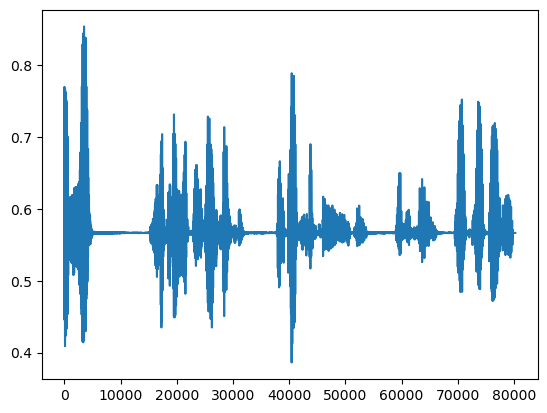

In [26]:
for x, _ in loader_train:
    print(torch.max(x), torch.min(x))
    plt.plot(np.arange(audio_dataset.max_length), x.flatten())
    plt.show()
    break

## Autoencoder class

In [67]:
class AutoEncoder(nn.Module):
    def __init__(self, wav_len):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(wav_len, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, wav_len),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))

## Training

In [82]:
model = AutoEncoder(audio_dataset.max_length)
opt = torch.optim.Adam(model.parameters())

for epoch in range(25):
    print(f'Epoch {epoch+1}/25', end=' ')
    for x, _ in loader_train:
        
        x_rec = model(x)
        loss = F.binary_cross_entropy(x_rec, x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        mse = F.mse_loss(x_rec, x)
        mae = F.l1_loss(x_rec, x)
    print(loss)
    print("Loss: {}; rmse: {}; mae:{}".format(loss.item(), np.sqrt(mse.item(), mae.item)))
    # print(f'\tloss: {loss.item():.4f} - rmse: {np.sqrt(mse.item()):.4f} - mae: {mae.item():.4f}')

Epoch 1/25 Asd
Asd
Asd
Asd
Asd
Asd
Asd


RuntimeError: all elements of target should be between 0 and 1